# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of industrial crop production in Italy 2006-2022
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2022. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).



In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
industrial_crop = pd.read_csv('./Italy_crop_data/industrial_crop.csv',skipinitialspace=True)
industrial_crop.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2006,2006,750,e,estimate data
1,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2007,2007,780,NaN,NaN
2,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2008,2008,810,NaN,NaN
3,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2009,2009,773,e,estimate data
4,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2010,2010,788,e,estimate data


## Pre-processing dataset 

In [3]:
# Drop Columns
industrial_crop = industrial_crop.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
industrial_crop

,Territory,Data type,Type of crop,Select time,Value
0,Cuneo,total production - quintals,parsley in greenhouses,2006,750
1,Cuneo,total production - quintals,parsley in greenhouses,2007,780
2,Cuneo,total production - quintals,parsley in greenhouses,2008,810
3,Cuneo,total production - quintals,parsley in greenhouses,2009,773
4,Cuneo,total production - quintals,parsley in greenhouses,2010,788
...,...,...,...,...,...
19180,Trentino Alto Adige / Südtirol,harvested production - quintals,hops,2021,60
19181,Grosseto,total area - hectares,other oilseed crops (excluding sesame),2021,72
19182,Udine,total area - hectares,hops,2021,1
19183,Arezzo,total area - hectares,other textile crops,2021,4


In [4]:
# Rename Columns
industrial_crop = industrial_crop.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(industrial_crop):
    print('DATASET SHAPE: ', industrial_crop.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(industrial_crop.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(industrial_crop.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(industrial_crop.isnull().sum())
show_info(industrial_crop)

DATASET SHAPE:  (19185, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19185 entries, 0 to 19184
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       19185 non-null  object
 1   Data_type  19185 non-null  object
 2   Type_crop  19185 non-null  object
 3   Year       19185 non-null  int64 
 4   Value      19185 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 749.5+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City          108
Data_type       4
Type_crop      18
Year           17
Value        4025
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing industrial crop

In [6]:
#industrial_crop.City.unique()


In [7]:
industrial_crop.Data_type.unique()

array(['total production - quintals ', 'harvested production - quintals ',
       'total area - ares', 'total area - hectares'], dtype=object)

## Select only Values for total industrial crop production - quintals


In [8]:
industrial_crop_prod = industrial_crop[industrial_crop['Data_type'] == 'total production - quintals ']
industrial_crop_prod.head()

,City,Data_type,Type_crop,Year,Value
0,Cuneo,total production - quintals,parsley in greenhouses,2006,750
1,Cuneo,total production - quintals,parsley in greenhouses,2007,780
2,Cuneo,total production - quintals,parsley in greenhouses,2008,810
3,Cuneo,total production - quintals,parsley in greenhouses,2009,773
4,Cuneo,total production - quintals,parsley in greenhouses,2010,788


In [9]:
industrial_crop_prod['Value'] = industrial_crop_prod['Value']/10
industrial_crop_prod

,City,Data_type,Type_crop,Year,Value
0,Cuneo,total production - quintals,parsley in greenhouses,2006,75.0
1,Cuneo,total production - quintals,parsley in greenhouses,2007,78.0
2,Cuneo,total production - quintals,parsley in greenhouses,2008,81.0
3,Cuneo,total production - quintals,parsley in greenhouses,2009,77.3
4,Cuneo,total production - quintals,parsley in greenhouses,2010,78.8
...,...,...,...,...,...
19137,Campobasso,total production - quintals,"other aromatic, medicinal and culinary plants",2021,15.0
19143,Reggio di Calabria,total production - quintals,"other aromatic, medicinal and culinary plants",2021,9.5
19144,Caserta,total production - quintals,"other aromatic, medicinal and culinary plants",2021,3352.0
19177,Trentino Alto Adige / Südtirol,total production - quintals,hops,2020,5.0


In [10]:
industrial_crop_prod = industrial_crop_prod.rename(columns = {'Value':'Total_production'})
industrial_crop_prod

,City,Data_type,Type_crop,Year,Total_production
0,Cuneo,total production - quintals,parsley in greenhouses,2006,75.0
1,Cuneo,total production - quintals,parsley in greenhouses,2007,78.0
2,Cuneo,total production - quintals,parsley in greenhouses,2008,81.0
3,Cuneo,total production - quintals,parsley in greenhouses,2009,77.3
4,Cuneo,total production - quintals,parsley in greenhouses,2010,78.8
...,...,...,...,...,...
19137,Campobasso,total production - quintals,"other aromatic, medicinal and culinary plants",2021,15.0
19143,Reggio di Calabria,total production - quintals,"other aromatic, medicinal and culinary plants",2021,9.5
19144,Caserta,total production - quintals,"other aromatic, medicinal and culinary plants",2021,3352.0
19177,Trentino Alto Adige / Südtirol,total production - quintals,hops,2020,5.0


In [11]:
industrial_crop_prod = industrial_crop_prod.drop(columns =['Data_type'])
industrial_crop_prod

,City,Type_crop,Year,Total_production
0,Cuneo,parsley in greenhouses,2006,75.0
1,Cuneo,parsley in greenhouses,2007,78.0
2,Cuneo,parsley in greenhouses,2008,81.0
3,Cuneo,parsley in greenhouses,2009,77.3
4,Cuneo,parsley in greenhouses,2010,78.8
...,...,...,...,...
19137,Campobasso,"other aromatic, medicinal and culinary plants",2021,15.0
19143,Reggio di Calabria,"other aromatic, medicinal and culinary plants",2021,9.5
19144,Caserta,"other aromatic, medicinal and culinary plants",2021,3352.0
19177,Trentino Alto Adige / Südtirol,hops,2020,5.0


## Total industrial crop production in 2006-2022

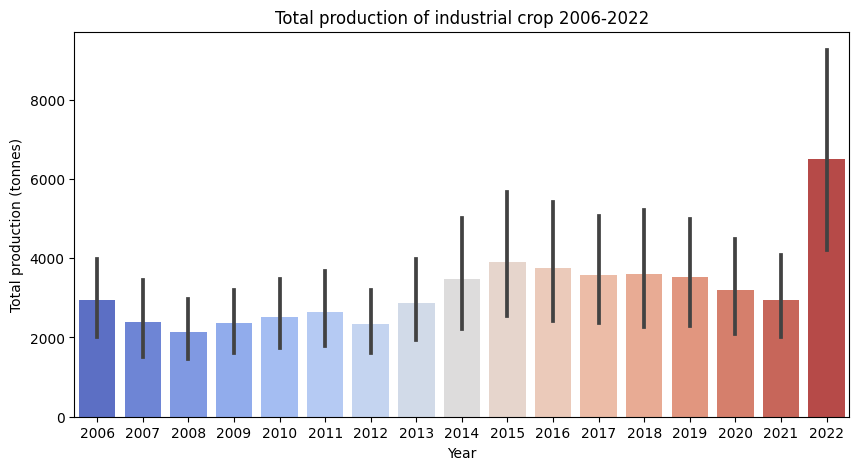

In [66]:
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Total_production',data = industrial_crop_prod, palette='coolwarm')
plt.title('Total production of industrial crop 2006-2022')
plt.xlabel('Year')
plt.ylabel('Total production (tonnes)')
plt.show()



## Industrial crop production by Cities 

In [13]:
industrial_crop_prod_region = industrial_crop_prod.groupby(by = industrial_crop_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False)
industrial_crop_prod_region



,City,Total_production
101,Venezia,2050509.3
98,Udine,1518676.9
83,Rovigo,1401013.8
31,Ferrara,1246983.0
63,Padova,1105870.4
...,...,...
42,La Spezia,44.7
60,Ogliastra,28.3
61,Olbia-Tempio,10.9
29,Enna,9.4


In [14]:
region = industrial_crop_prod_region.nlargest(30, 'Total_production')

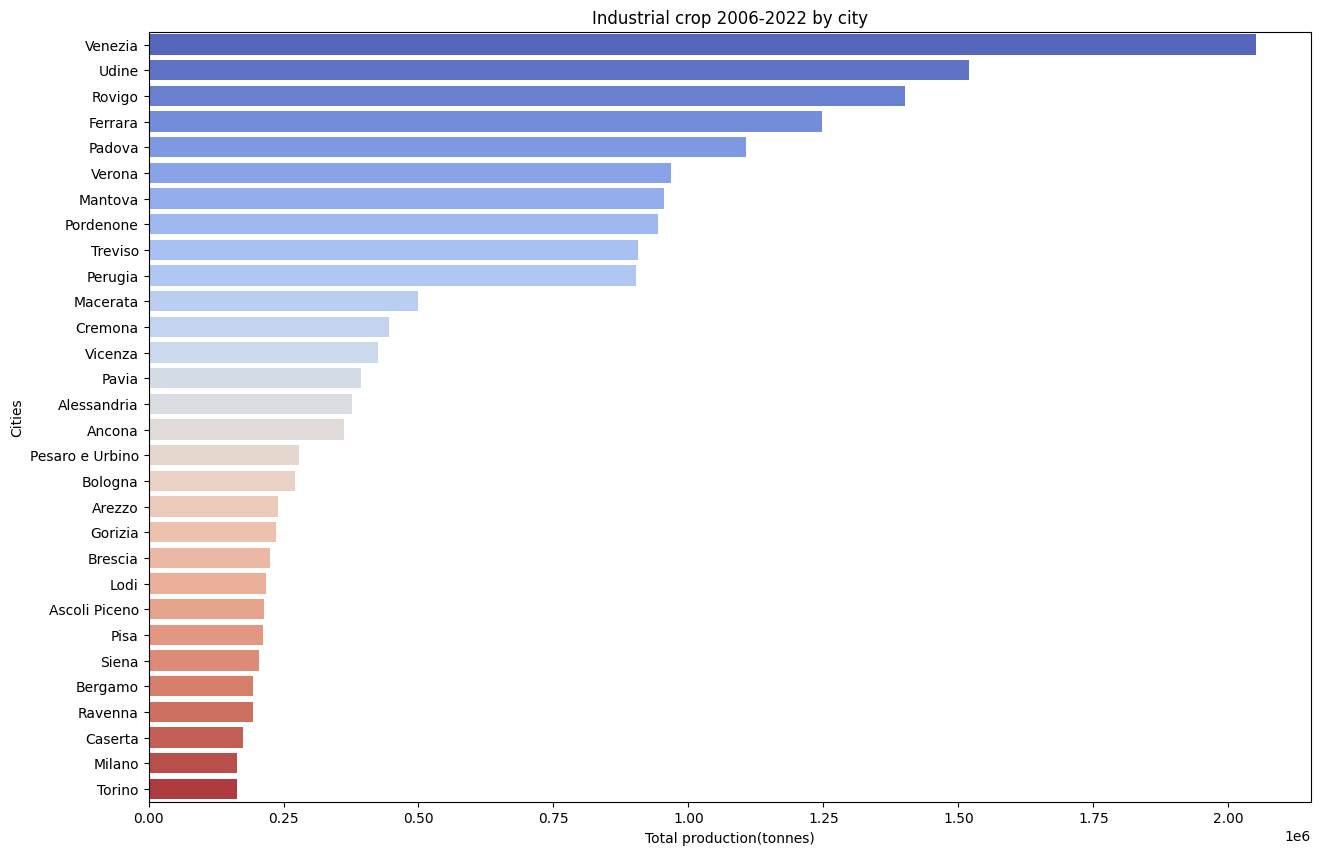

In [65]:
plt.figure(figsize= (15, 10))
sns.barplot(x= region['Total_production'],y= region['City'], orient='h', palette='coolwarm');
plt.title('Industrial crop 2006-2022 by city')
plt.xlabel('Total production(tonnes)')
plt.ylabel('Cities')
plt.show() 

##  Industrial crop  2006-2022

In [16]:
print(industrial_crop_prod.Type_crop.max())
print(industrial_crop_prod.Type_crop.value_counts())
print(industrial_crop_prod.Type_crop.nunique())



valerian in greenhouses
sunflower                                        1204
rape                                             1023
soya beans                                        986
sweet basil in greenhouses                        654
parsley in open field                             624
parsley in greenhouses                            585
tobacco                                           352
valerian in greenhouses                           327
hemp                                              320
flax                                              127
turnip rape                                        77
groundnut                                          51
hops                                               33
sesame                                              8
other aromatic, medicinal and culinary plants       8
cotton                                              5
other textile crops                                 2
other oilseed crops (excluding sesame)              1
Name

Dataset shows there are 17 different types of industrial crop cultivated in Italy. The top most produced crops are : Valerian, Greenhouses, Sunflower, Rape, Soya beans, Hemp, Parsley in open field, Sweet basil in greenhouses, Parsley in greenhouses, Tobacco, Flax. 


In [17]:
industrial_crop_prod.describe()

,Year,Total_production
count,6387.000000,6387.000000
mean,2014.166902,3153.793424
std,4.763694,12418.126771
min,2006.000000,0.000000
25%,2010.000000,24.000000
50%,2014.000000,150.000000
75%,2018.000000,930.000000
max,2022.000000,173978.000000


In [18]:
industrial_crop_prod = industrial_crop_prod.replace('valerian in greenhouses','valerian-ghouse')
industrial_crop_prod = industrial_crop_prod.replace('sweet basil in greenhouses','basil-ghouse')
industrial_crop_prod = industrial_crop_prod.replace('other aromatic, medicinal and culinary plants','aromatic-medicinal')
industrial_crop_prod = industrial_crop_prod.replace('parsley in greenhouses','parsley-ghouse')
industrial_crop_prod = industrial_crop_prod.replace('parsley in open field','parsley-field')
industrial_crop_prod = industrial_crop_prod.replace('other oilseed crops (excluding sesame)','oilseeds(No-sesame)')
industrial_crop_prod = industrial_crop_prod.replace('other textile crops','textile-crops')

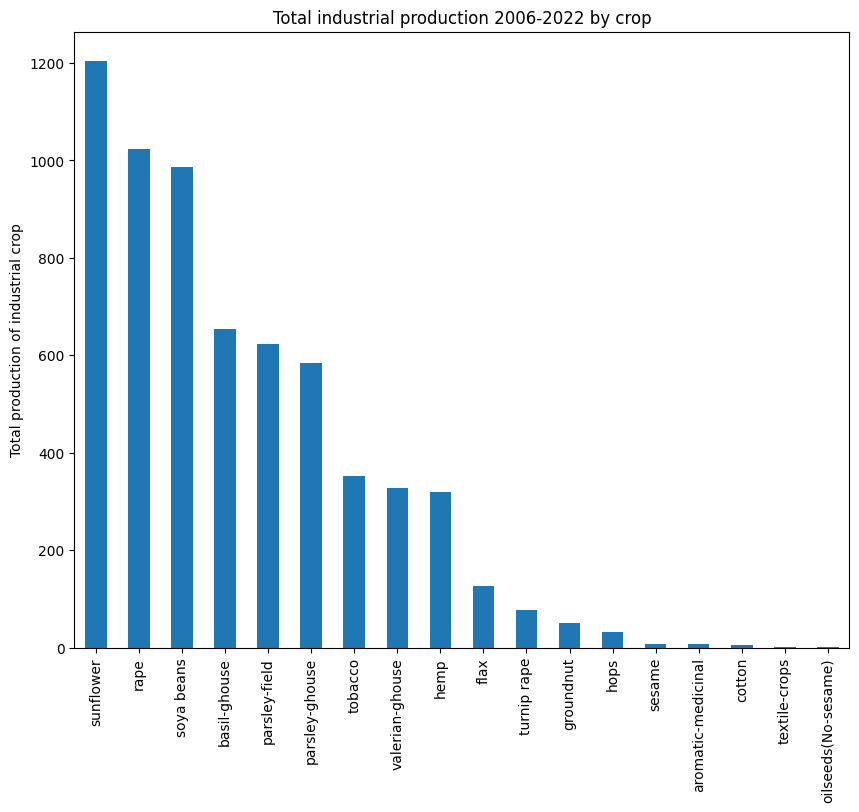

In [19]:
plt.figure(figsize=(10,8))
industrial_crop_prod ['Type_crop'].value_counts().plot.bar()
plt.title('Total industrial production 2006-2022 by crop')
plt.ylabel('Total production of industrial crop')
plt.show()


## Subseting data

In [20]:
industrial_crop_top10 = industrial_crop_prod.apply(lambda row: row[industrial_crop_prod['Type_crop'].isin(['valerian-ghouse', 'basil-ghouse', 'sunflower', 'rape', 
                                                                                                           'soya beans', 'hemp', 'parsley-field', 
                                                                                                           'parsley-ghouse', 'tobacco', 'flax'])])

industrial_crop_top10.head()

,City,Type_crop,Year,Total_production
0,Cuneo,parsley-ghouse,2006,75.0
1,Cuneo,parsley-ghouse,2007,78.0
2,Cuneo,parsley-ghouse,2008,81.0
3,Cuneo,parsley-ghouse,2009,77.3
4,Cuneo,parsley-ghouse,2010,78.8


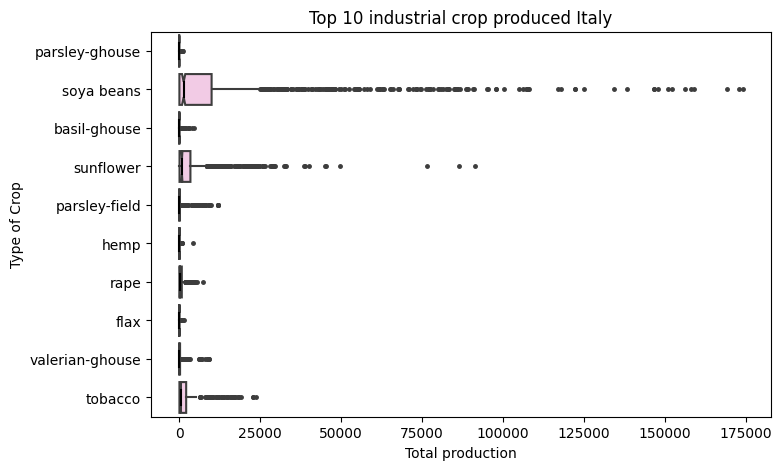

In [21]:
plt.figure(figsize=(8,5))

sns.boxplot(
    data=industrial_crop_top10, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.9, .6, .8, .5)},
    medianprops={"color": "black"},
)
plt.title('Top 10 industrial crop produced Italy')
plt.ylabel('Type of Crop')
plt.xlabel('Total production')
plt.show()

In [22]:
industrial_crop_top10

,City,Type_crop,Year,Total_production
0,Cuneo,parsley-ghouse,2006,75.0
1,Cuneo,parsley-ghouse,2007,78.0
2,Cuneo,parsley-ghouse,2008,81.0
3,Cuneo,parsley-ghouse,2009,77.3
4,Cuneo,parsley-ghouse,2010,78.8
...,...,...,...,...
19044,La Spezia,tobacco,2019,44.7
19045,Gorizia,tobacco,2019,53.7
19046,Sud Sardegna,parsley-ghouse,2020,146.1
19047,Sud Sardegna,parsley-ghouse,2021,146.1


## Vizualization of ten type of industrial crop produced in Italy in the period of 2006-2022 

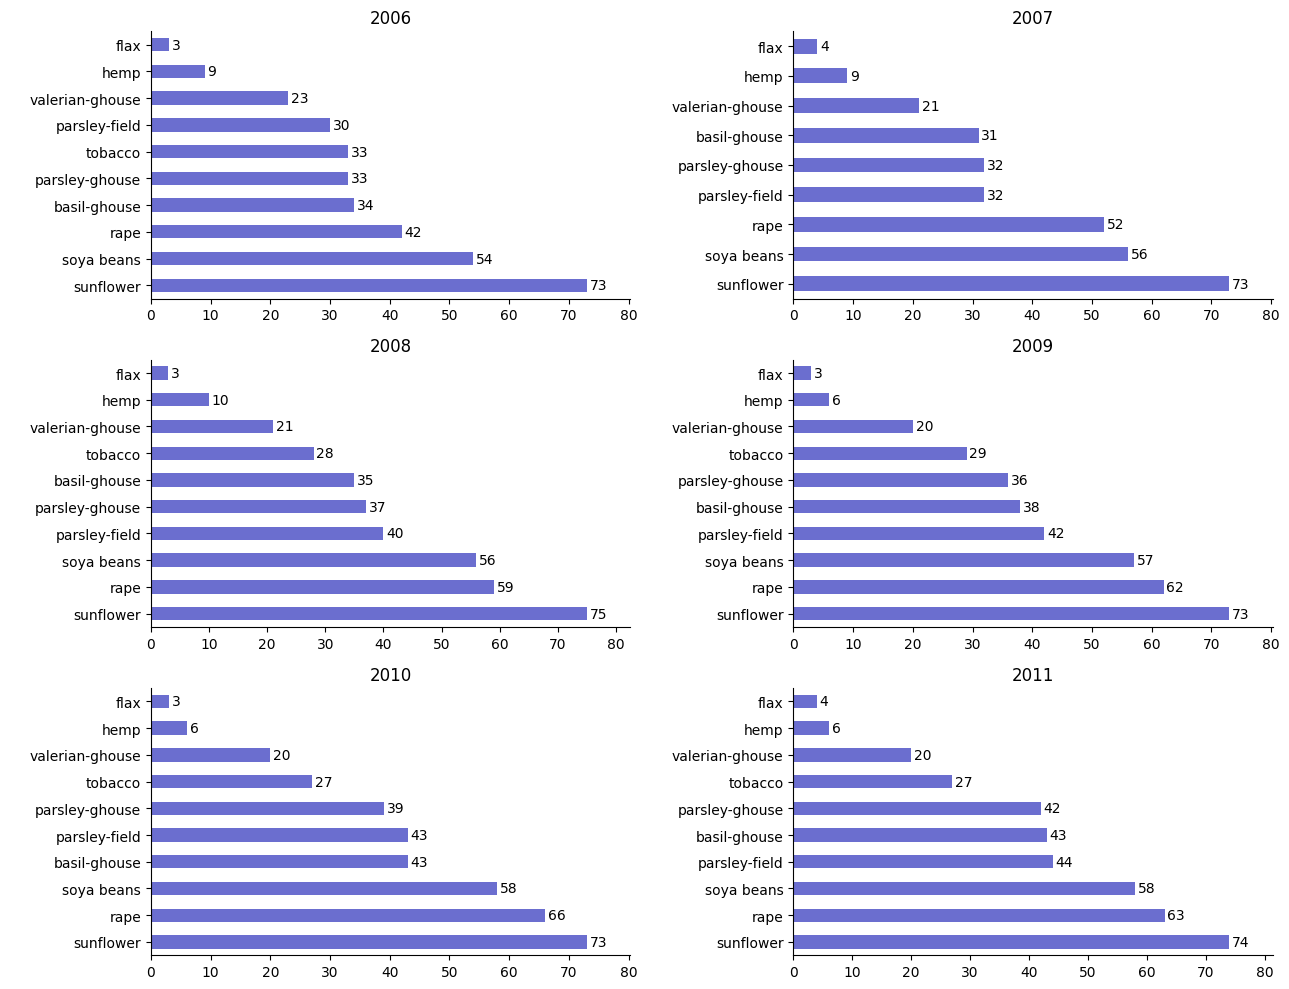

In [23]:
fig, axs = plt.subplots(3,2, figsize=(13, 10))
plt.ylabel(" ")

plot1 = industrial_crop_top10[industrial_crop_top10.Year == 2006].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2006', ax=axs[0,0])
plot2 = industrial_crop_top10[industrial_crop_top10.Year == 2007].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2007', ax=axs[0,1])
plot3 = industrial_crop_top10[industrial_crop_top10.Year == 2008].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2008', ax=axs[1,0])
plot4 = industrial_crop_top10[industrial_crop_top10.Year == 2009].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2009', ax=axs[1,1])
plot5 = industrial_crop_top10[industrial_crop_top10.Year == 2010].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2010', ax=axs[2,0])
plot6 = industrial_crop_top10[industrial_crop_top10.Year == 2011].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2011', ax=axs[2,1])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
    sns.despine()

plt.tight_layout()
plt.show()



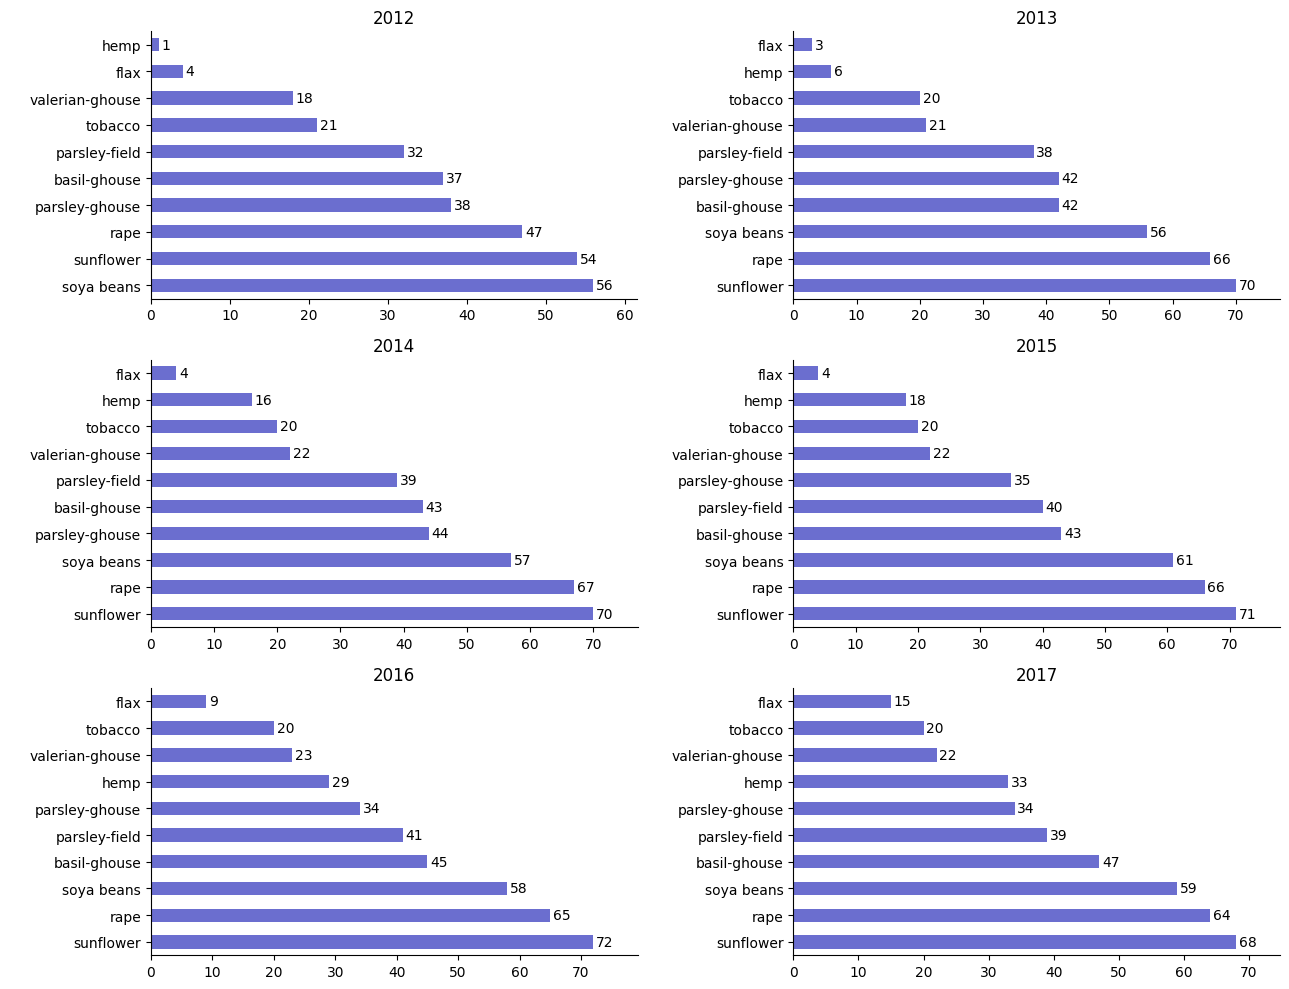

In [24]:
fig, axs = plt.subplots(3,2, figsize=(13, 10))


plot7 = industrial_crop_top10[industrial_crop_top10.Year == 2012].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2012', ax=axs[0,0])
plot8 = industrial_crop_top10[industrial_crop_top10.Year == 2013].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2013', ax=axs[0,1])
plot9 = industrial_crop_top10[industrial_crop_top10.Year == 2014].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2014', ax=axs[1,0])
plot10 = industrial_crop_top10[industrial_crop_top10.Year == 2015].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2015', ax=axs[1,1])
plot11 = industrial_crop_top10[industrial_crop_top10.Year == 2016].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2016', ax=axs[2,0])
plot12 = industrial_crop_top10[industrial_crop_top10.Year == 2017].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2017', ax=axs[2,1])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
    sns.despine()
    
plt.tight_layout()
plt.show()

IndexError: list index out of range

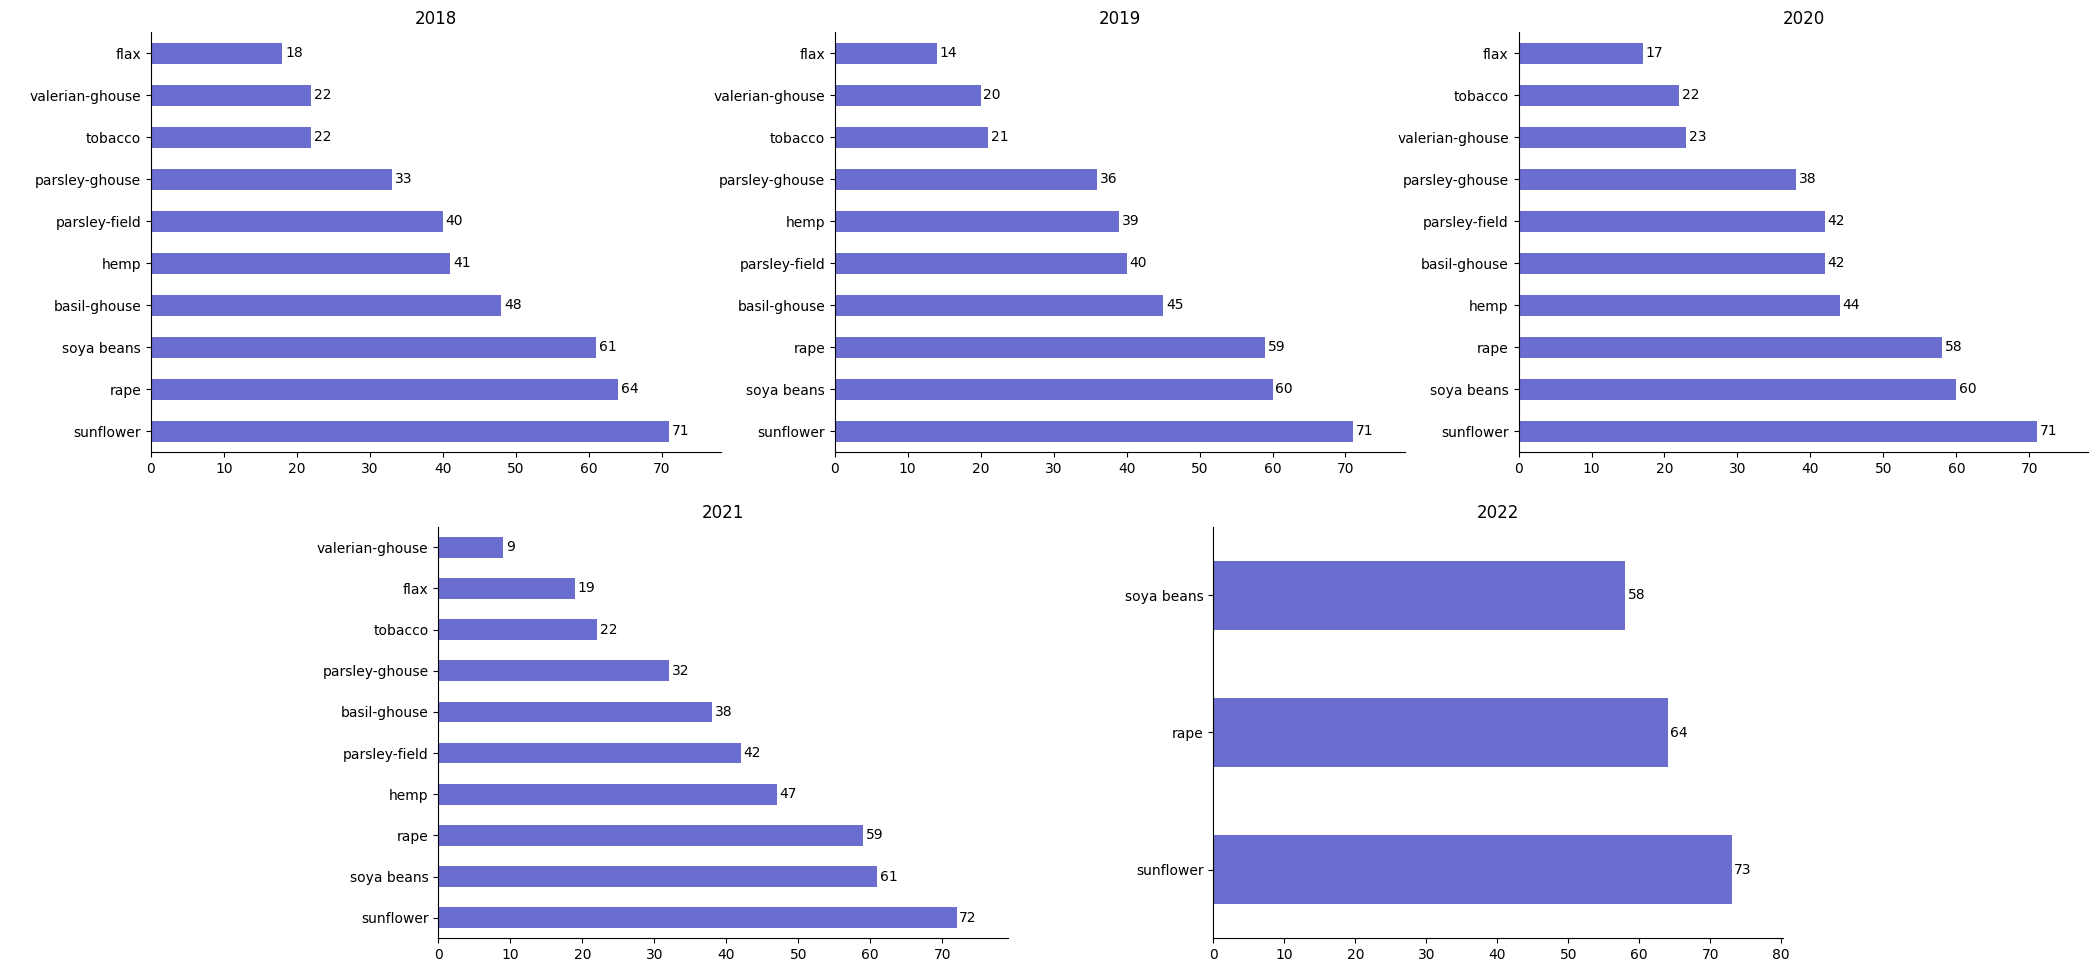

In [25]:
fig, axs = plt.subplots(2,3, figsize=(25,12))

axs[1,0].set_position([0.24,0.125,0.228,0.343])
axs[1,1].set_position([0.55,0.125,0.228,0.343])
axs[1,2].set_visible(False)

plot13 = industrial_crop_top10[industrial_crop_top10.Year == 2018].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2018', ax=axs[0,0])
plot14 = industrial_crop_top10[industrial_crop_top10.Year == 2019].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2019', ax=axs[0,1])
plot15 = industrial_crop_top10[industrial_crop_top10.Year == 2020].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2020', ax=axs[0,2])
plot16 = industrial_crop_top10[industrial_crop_top10.Year == 2021].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2021', ax=axs[1,0])
plot17 = industrial_crop_top10[industrial_crop_top10.Year == 2022].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2022', ax=axs[1,1])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
    sns.despine()

plt.tight_layout()

plt.show()


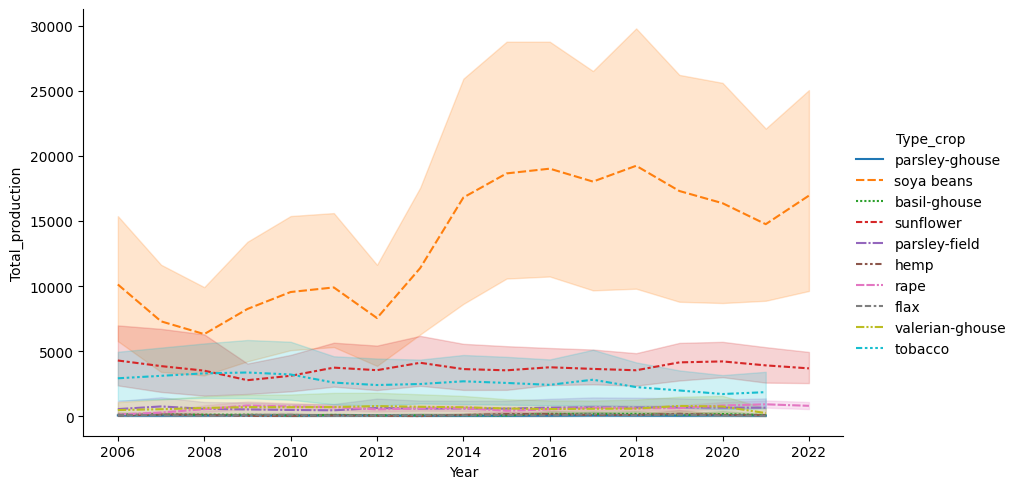

In [26]:
#Crop harvested by year
plotcrop10 = sns.relplot(kind='line', data=industrial_crop_top10, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


In [27]:
# Select year 2020 for future join with fertilizer
industrial_crop_top10 = industrial_crop_top10[industrial_crop_top10['Year'] == 2020]
industrial_crop_top10



,City,Type_crop,Year,Total_production
14,Cuneo,parsley-ghouse,2020,35.0
77,Varese,parsley-ghouse,2020,0.5
122,Lecco,parsley-ghouse,2020,30.0
166,Milano,parsley-ghouse,2020,58.0
239,Brescia,parsley-ghouse,2020,125.0
...,...,...,...,...
19003,Latina,tobacco,2020,1.4
19023,Ferrara,tobacco,2020,367.5
19030,Foggia,tobacco,2020,0.7
19034,Sud Sardegna,basil-ghouse,2020,60.6


### Create columns for each type crop 

In [28]:
# Create columns for each type crop
industrial_crop_top10_pivot = industrial_crop_top10.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
industrial_crop_top10_pivot

Total_production                              \
Type_crop                     basil-ghouse   flax   hemp parsley-field   
City                 Year                                                
Agrigento            2020              NaN    NaN    NaN          15.5   
Alessandria          2020              NaN  132.0  104.0         612.0   
Ancona               2020              1.5    NaN  230.0           NaN   
Arezzo               2020              3.0    4.0  665.0          14.0   
Ascoli Piceno        2020              0.2    NaN    NaN          40.0   
...                                    ...    ...    ...           ...   
Verbano-Cusio-Ossola 2020              NaN    NaN    7.5           NaN   
Vercelli             2020              NaN    NaN    NaN           NaN   
Verona               2020           4530.9    NaN  516.0         108.0   
Vicenza              2020              NaN    4.0   60.0           NaN   
Viterbo              2020              NaN  115.0   21.5           NaN   

                                                                               \
Type_crop                 parsley-ghouse    rape soya beans sunflower tobacco   
City                 Year                                                       
Agrigento            2020            NaN     NaN        NaN       NaN     NaN   
Alessandria          2020            NaN  2897.5    11924.5   17730.0     NaN   
Ancona               2020            0.2   207.0      473.6   24043.5     NaN   
Arezzo               2020            1.2  1053.0      125.0   11970.0  2216.4   
Ascoli Piceno        2020            0.7     NaN       77.6   15065.9     NaN   
...                                  ...     ...        ...       ...     ...   
Verbano-Cusio-Ossola 2020            NaN     NaN       45.0       NaN     NaN   
Vercelli             2020            NaN   416.3     7099.2     110.7     NaN   
Verona               2020          951.5  2151.5    48016.0    8583.0  9810.6   
Vicenza              2020            NaN  1059.0    36808.0    1465.0   755.9   
Viterbo              2020            NaN    55.0        NaN    1690.0   269.9   

                                           
Type_crop                 valerian-ghouse  
City                 Year                  
Agrigento            2020             NaN  
Alessandria          2020             NaN  
Ancona               2020             NaN  
Arezzo               2020             NaN  
Ascoli Piceno        2020             NaN  
...                                   ...  
Verbano-Cusio-Ossola 2020             NaN  
Vercelli             2020             NaN  
Verona               2020           780.0  
Vicenza              2020            47.0  
Viterbo              2020             NaN  

[97 rows x 10 columns]

In [29]:
# Drop level
industrial_crop_top10_pivot.columns = industrial_crop_top10_pivot.columns.droplevel()
industrial_crop_top10_pivot

,Type_crop,basil-ghouse,flax,hemp,parsley-field,parsley-ghouse,rape,soya beans,sunflower,tobacco,valerian-ghouse
City,Year,,,,,,,,,,
Agrigento,2020,NaN,NaN,NaN,15.5,NaN,NaN,NaN,NaN,NaN,NaN
Alessandria,2020,NaN,132.0,104.0,612.0,NaN,2897.5,11924.5,17730.0,NaN,NaN
Ancona,2020,1.5,NaN,230.0,NaN,0.2,207.0,473.6,24043.5,NaN,NaN
Arezzo,2020,3.0,4.0,665.0,14.0,1.2,1053.0,125.0,11970.0,2216.4,NaN
Ascoli Piceno,2020,0.2,NaN,NaN,40.0,0.7,NaN,77.6,15065.9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Verbano-Cusio-Ossola,2020,NaN,NaN,7.5,NaN,NaN,NaN,45.0,NaN,NaN,NaN
Vercelli,2020,NaN,NaN,NaN,NaN,NaN,416.3,7099.2,110.7,NaN,NaN
Verona,2020,4530.9,NaN,516.0,108.0,951.5,2151.5,48016.0,8583.0,9810.6,780.0


In [30]:
industrial_crop_top10_pivot = industrial_crop_top10_pivot.fillna(0)
industrial_crop_top10_pivot

,Type_crop,basil-ghouse,flax,hemp,parsley-field,parsley-ghouse,rape,soya beans,sunflower,tobacco,valerian-ghouse
City,Year,,,,,,,,,,
Agrigento,2020,0.0,0.0,0.0,15.5,0.0,0.0,0.0,0.0,0.0,0.0
Alessandria,2020,0.0,132.0,104.0,612.0,0.0,2897.5,11924.5,17730.0,0.0,0.0
Ancona,2020,1.5,0.0,230.0,0.0,0.2,207.0,473.6,24043.5,0.0,0.0
Arezzo,2020,3.0,4.0,665.0,14.0,1.2,1053.0,125.0,11970.0,2216.4,0.0
Ascoli Piceno,2020,0.2,0.0,0.0,40.0,0.7,0.0,77.6,15065.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
Verbano-Cusio-Ossola,2020,0.0,0.0,7.5,0.0,0.0,0.0,45.0,0.0,0.0,0.0
Vercelli,2020,0.0,0.0,0.0,0.0,0.0,416.3,7099.2,110.7,0.0,0.0
Verona,2020,4530.9,0.0,516.0,108.0,951.5,2151.5,48016.0,8583.0,9810.6,780.0


In [31]:
#Rename index
industrial_crop_top10_pivot = industrial_crop_top10_pivot.rename_axis(None,axis=1)
industrial_crop_top10_pivot

,,basil-ghouse,flax,hemp,parsley-field,parsley-ghouse,rape,soya beans,sunflower,tobacco,valerian-ghouse
City,Year,,,,,,,,,,
Agrigento,2020,0.0,0.0,0.0,15.5,0.0,0.0,0.0,0.0,0.0,0.0
Alessandria,2020,0.0,132.0,104.0,612.0,0.0,2897.5,11924.5,17730.0,0.0,0.0
Ancona,2020,1.5,0.0,230.0,0.0,0.2,207.0,473.6,24043.5,0.0,0.0
Arezzo,2020,3.0,4.0,665.0,14.0,1.2,1053.0,125.0,11970.0,2216.4,0.0
Ascoli Piceno,2020,0.2,0.0,0.0,40.0,0.7,0.0,77.6,15065.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
Verbano-Cusio-Ossola,2020,0.0,0.0,7.5,0.0,0.0,0.0,45.0,0.0,0.0,0.0
Vercelli,2020,0.0,0.0,0.0,0.0,0.0,416.3,7099.2,110.7,0.0,0.0
Verona,2020,4530.9,0.0,516.0,108.0,951.5,2151.5,48016.0,8583.0,9810.6,780.0


In [32]:
# Reset index
industrial_crop_top10_pivot = industrial_crop_top10_pivot.reset_index()
industrial_crop_top10_pivot

,City,Year,basil-ghouse,flax,hemp,parsley-field,parsley-ghouse,rape,soya beans,sunflower,tobacco,valerian-ghouse
0,Agrigento,2020,0.0,0.0,0.0,15.5,0.0,0.0,0.0,0.0,0.0,0.0
1,Alessandria,2020,0.0,132.0,104.0,612.0,0.0,2897.5,11924.5,17730.0,0.0,0.0
2,Ancona,2020,1.5,0.0,230.0,0.0,0.2,207.0,473.6,24043.5,0.0,0.0
3,Arezzo,2020,3.0,4.0,665.0,14.0,1.2,1053.0,125.0,11970.0,2216.4,0.0
4,Ascoli Piceno,2020,0.2,0.0,0.0,40.0,0.7,0.0,77.6,15065.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
92,Verbano-Cusio-Ossola,2020,0.0,0.0,7.5,0.0,0.0,0.0,45.0,0.0,0.0,0.0
93,Vercelli,2020,0.0,0.0,0.0,0.0,0.0,416.3,7099.2,110.7,0.0,0.0
94,Verona,2020,4530.9,0.0,516.0,108.0,951.5,2151.5,48016.0,8583.0,9810.6,780.0
95,Vicenza,2020,0.0,4.0,60.0,0.0,0.0,1059.0,36808.0,1465.0,755.9,47.0


## Statistical analysis

In [33]:
industrial_crop_top10_pivot.describe()

,Year,basil-ghouse,flax,hemp,parsley-field,parsley-ghouse,rape,soya beans,sunflower,tobacco,valerian-ghouse
count,97.0,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,2020.0,80.111340,12.860825,48.927835,291.496907,32.942268,502.221649,10122.530928,3090.926804,390.006186,181.249485
std,0.0,470.681385,49.489739,113.973001,1390.266277,135.831656,837.225153,27059.120462,5521.124257,1668.361953,895.648620
min,2020.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2020.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2020.0,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,60.000000,575.000000,0.000000,0.000000
75%,2020.0,20.600000,0.000000,40.000000,48.100000,5.000000,608.400000,4680.000000,3090.000000,0.000000,0.000000
max,2020.0,4530.900000,385.000000,665.000000,12000.000000,951.500000,3570.000000,134340.000000,26014.200000,11323.200000,8000.000000


#### Data metrics : skew, kurtosis and mode

In [34]:
industrial_crop_top10_pivot_stats = industrial_crop_top10_pivot[['valerian-ghouse', 'basil-ghouse', 'sunflower', 'rape', 
                                                                 'soya beans', 'hemp', 'parsley-field','parsley-ghouse',
                                                                 'tobacco', 'flax']]
print(industrial_crop_top10_pivot_stats.astype(float).skew())
print(industrial_crop_top10_pivot_stats.astype(float).kurtosis())
print(industrial_crop_top10_pivot_stats.astype(float).mode())


valerian-ghouse    7.580094
basil-ghouse       9.072521
sunflower          2.498024
rape               2.075133
soya beans         3.461203
hemp               3.779253
parsley-field      7.090624
parsley-ghouse     6.107604
tobacco            5.435259
flax               5.481242
dtype: float64
valerian-ghouse    63.054889
basil-ghouse       85.726209
sunflower           6.147476
rape                3.717091
soya beans         11.834538
hemp               15.925021
parsley-field      55.256227
parsley-ghouse     38.595344
tobacco            30.523822
flax               35.272695
dtype: float64
   valerian-ghouse  basil-ghouse  sunflower  rape  soya beans  hemp  \
0              0.0           0.0        0.0   0.0         0.0   0.0   

   parsley-field  parsley-ghouse  tobacco  flax  
0            0.0             0.0      0.0   0.0  


## Graphs

#### Histogram and Boxplot showing data distribuion and outliers¶
 
Normalizing the dataset

The data need to be normalized for further use in a modelling. Here the data will be normalize by deleting outliers using the interquartile range (IQR).

Calculate and print the interquartile range

In [35]:
Q1 = industrial_crop_top10_pivot_stats.quantile(0.25)
Q3 = industrial_crop_top10_pivot_stats.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


valerian-ghouse       0.0
basil-ghouse         20.6
sunflower          3090.0
rape                608.4
soya beans         4680.0
hemp                 40.0
parsley-field        48.1
parsley-ghouse        5.0
tobacco               0.0
flax                  0.0
dtype: float64


### Remove outliers and plot graphs

In [36]:
# Remove outliers
industrial_crop_top10_pivot_stats[~((industrial_crop_top10_pivot < (Q1 - 1.5 * IQR)) | (industrial_crop_top10_pivot_stats > (Q3 + 1.5 * IQR))).any(axis=1)]
print(industrial_crop_top10_pivot.shape)

(97, 12)


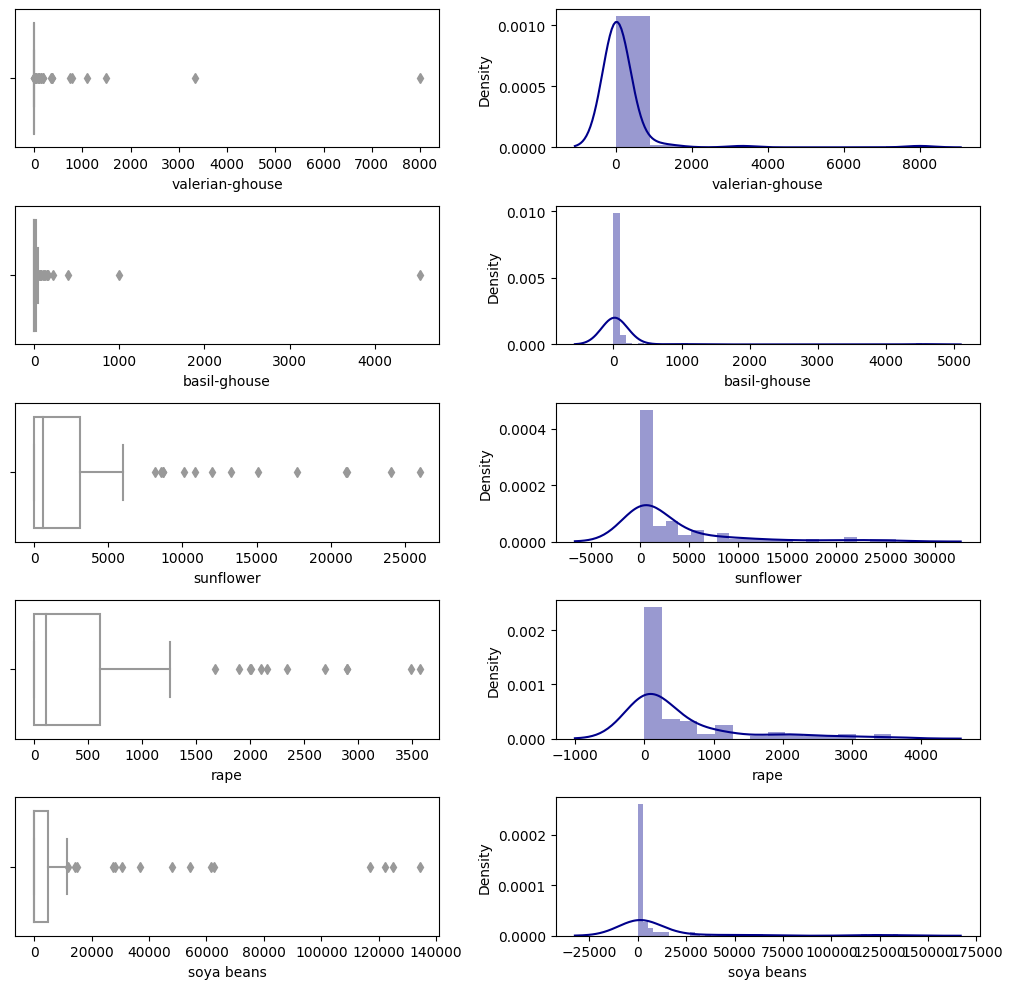

In [37]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= industrial_crop_top10_pivot_stats["valerian-ghouse"], color = 'white', ax = ax[0,0])
sns.distplot(industrial_crop_top10_pivot_stats['valerian-ghouse'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["basil-ghouse"],color = 'white', ax = ax[1,0])
sns.distplot(industrial_crop_top10_pivot_stats['basil-ghouse'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["sunflower"],color = 'white', ax = ax[2,0])
sns.distplot(industrial_crop_top10_pivot_stats['sunflower'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["rape"], color = 'white', ax = ax[3,0])
sns.distplot(industrial_crop_top10_pivot_stats['rape'], color = 'darkblue', ax = ax[3,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["soya beans"], color = 'white',ax = ax[4,0])
sns.distplot(industrial_crop_top10_pivot_stats['soya beans'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

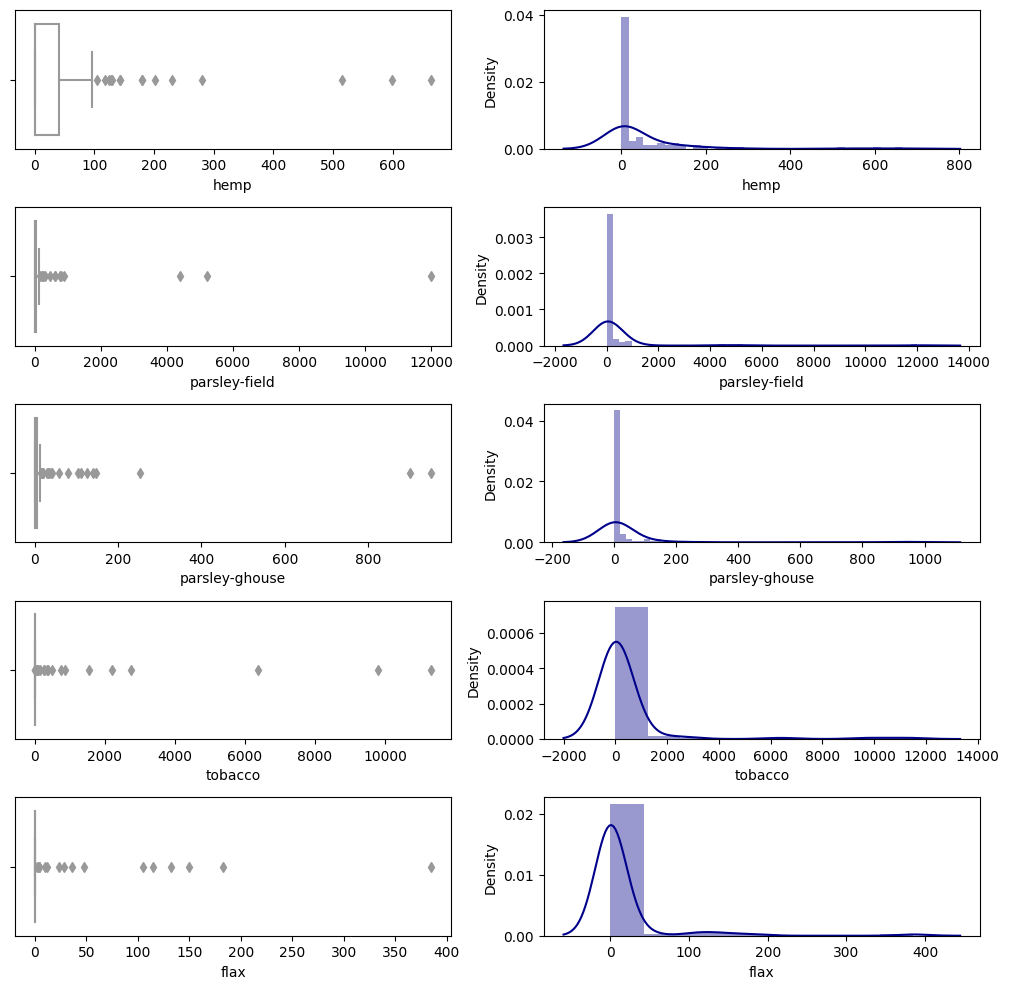

In [38]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= industrial_crop_top10_pivot_stats["hemp"], color = 'white', ax = ax[0,0])
sns.distplot(industrial_crop_top10_pivot_stats['hemp'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["parsley-field"],color = 'white', ax = ax[1,0])
sns.distplot(industrial_crop_top10_pivot_stats['parsley-field'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["parsley-ghouse"],color = 'white', ax = ax[2,0])
sns.distplot(industrial_crop_top10_pivot_stats['parsley-ghouse'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["tobacco"], color = 'white',ax = ax[3,0])
sns.distplot(industrial_crop_top10_pivot_stats['tobacco'], color = 'darkblue',ax = ax[3,1])
sns.boxplot(x= industrial_crop_top10_pivot_stats["flax"], color = 'white',ax = ax[4,0])
sns.distplot(industrial_crop_top10_pivot_stats['flax'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

## Pre-processing ferlizers dataset

fertilizers distributed - tonnes


In [39]:
fertilizer = pd.read_csv('fertilizer_by_prov.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2006,2006,1227,NaN,NaN
1,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2007,2007,1812,NaN,NaN
2,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2008,2008,5224,NaN,NaN
3,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2009,2009,2051,NaN,NaN
4,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2010,2010,54,NaN,NaN


In [40]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags' ])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [41]:
#fertilizer.Territory.unique()

In [42]:
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [43]:
#convert quintals to tonnes
fertilizer.loc[fertilizer['Data_type'] == 'fertilizers distributed - quintals','Fertilizers_tonnes' ] = fertilizer['Fertilizers_tonnes'] / 10


In [44]:
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,122.7
1,Torino,calcium cyanamide,2007,181.2
2,Torino,calcium cyanamide,2008,522.4
3,Torino,calcium cyanamide,2009,205.1
4,Torino,calcium cyanamide,2010,5.4
...,...,...,...,...
68381,Sud Sardegna,specific action products -,2017,335.0
68382,Sud Sardegna,specific action products -,2018,137.0
68383,Sud Sardegna,specific action products -,2019,164.0
68384,Sud Sardegna,specific action products -,2020,135.0


In [45]:
fertilizer.Type_fertilizer.unique()

array(['calcium cyanamide', 'nitrates ', 'ammonium sulphate', 'urea',
       'other fertilizers different from calcium cyanamide, nitrates, ammonium sulphate, urea',
       'simple superphosphate', 'triple superphosphate',
       'other fertilizers different from simple superphosphate and triple superphosphate',
       'sulphate', 'chloride ',
       'other fertilizers different from sulphate and chloride ',
       'two components - nitrogen-phosphorous',
       'two components - phosphorus-potassium',
       'two components - nitrogen-potassium',
       'three components - nitrogen-phosphorous-phosphorous',
       'containing only one secondary macronutrient - calcium oxide',
       'containing only one secondary macronutrient - magnesium oxide',
       'containing only one secondary macronutrient - sulphur oxide',
       'containing only one secondary macronutrient',
       'containing micronutrients containing only a micronutrient in mineral form',
       'containing micronutrients 

In [46]:
fertilizer.Year.unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021])

### Selecting fertilizers for future analysis 

In [47]:
print(fertilizer.Type_fertilizer.max())
print(fertilizer.Type_fertilizer.value_counts())
print(fertilizer.Type_fertilizer.nunique())

vegetable soil amendment
specific action products -                                                               3497
three components - nitrogen-phosphorous-phosphorous                                      1941
containing only one secondary macronutrient - magnesium oxide                            1749
soil correctives - other  soil correctives                                               1749
other soil amendments                                                                    1749
peaty soil amendment                                                                     1749
mixed soil amendment                                                                     1749
vegetable soil amendment                                                                 1749
organic-mineral fertilizers - compound                                                   1749
organic-mineral fertilizers - straight nitrogen                                          1749
organic fertilizers - compound     

In [48]:
# Rename name of fertilizers 
fertilizer = fertilizer.replace('organic fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - compound','organic-mineral')
fertilizer = fertilizer.replace('organic fertilizers - compound','organic')
fertilizer = fertilizer.replace('mixed soil amendment','mix-amend')
fertilizer = fertilizer.replace('peaty soil amendment','peaty-amend')
fertilizer = fertilizer.replace('peaty amendment','peaty-amend')
fertilizer = fertilizer.replace('peat amendment','peaty-amend')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - nitrogen-potassium','nitrogen-potassium')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - phosphorus-potassium','phosphorus-potassium')
fertilizer = fertilizer.replace('vegetable soil amendment', 'organic')

In [49]:
fertilizer = fertilizer.apply(lambda row: row[fertilizer['Type_fertilizer'].isin(['calcium cyanamide ','nitrates','organic', 'urea','nitrogen-potassium',
                                                                                  'phosphorus-potassium','ammonium sulphate','calcium cyanamide', 
                                                                                  'nitrogen-phosphorous','peaty-amend','organic-nitrogen' ])])

fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,122.7
1,Torino,calcium cyanamide,2007,181.2
2,Torino,calcium cyanamide,2008,522.4
3,Torino,calcium cyanamide,2009,205.1
4,Torino,calcium cyanamide,2010,5.4


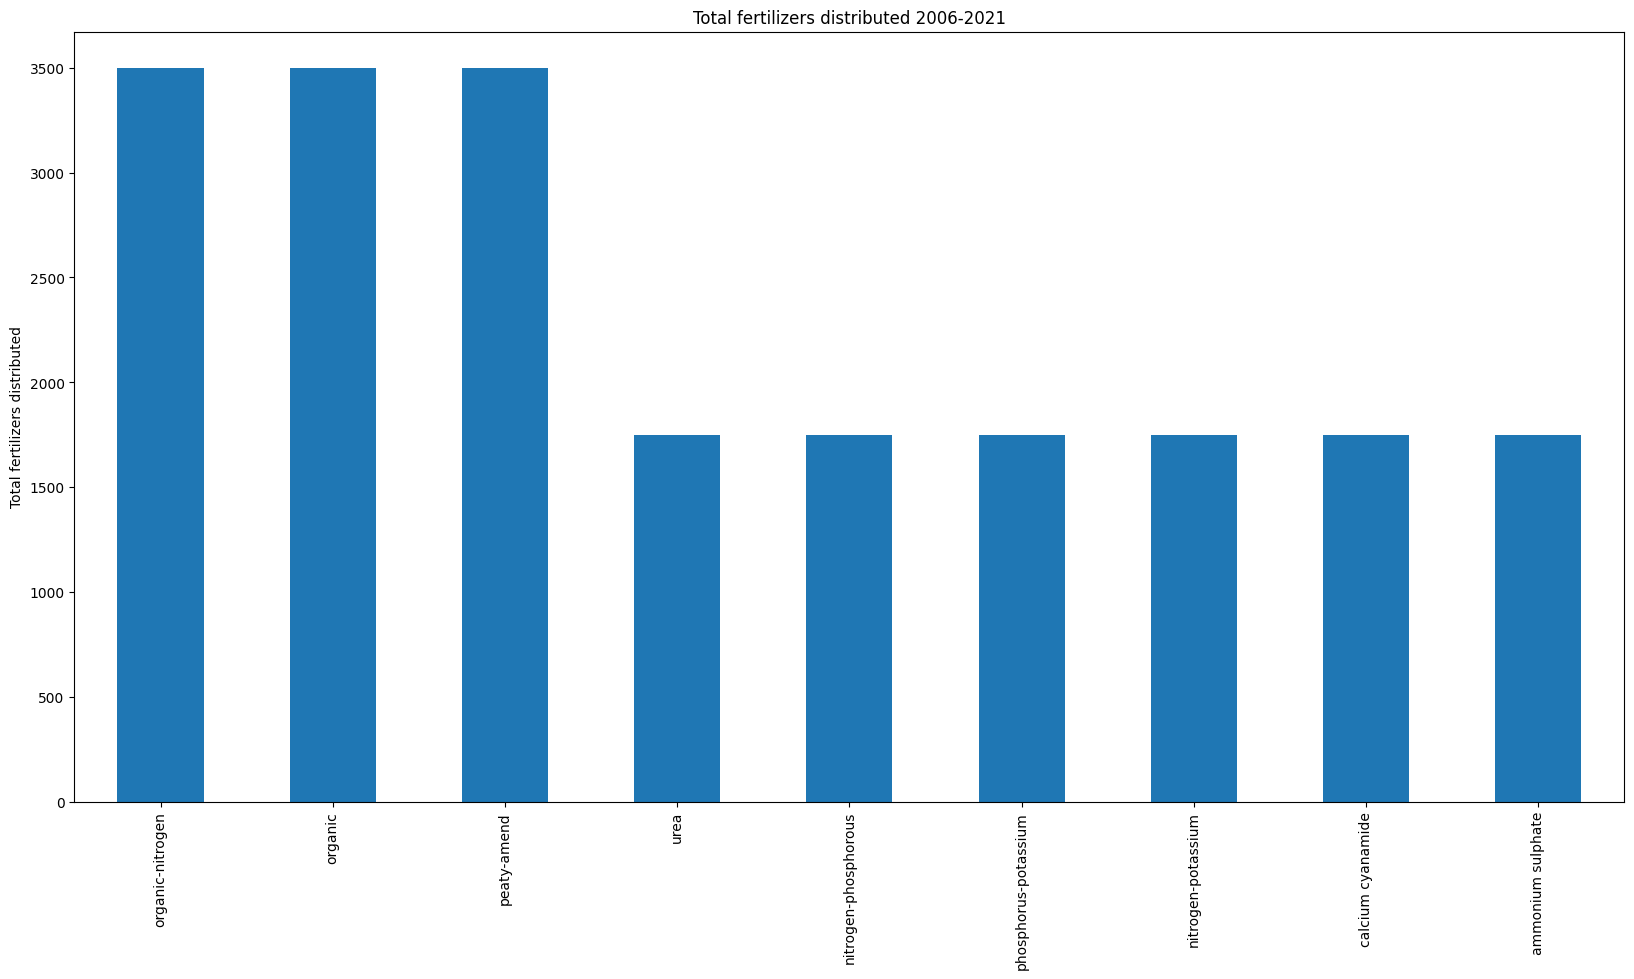

In [50]:
plt.figure(figsize=(20,10))
fertilizer['Type_fertilizer'].value_counts().plot.bar()
plt.title('Total fertilizers distributed 2006-2021')
plt.ylabel('Total fertilizers distributed')
plt.show()

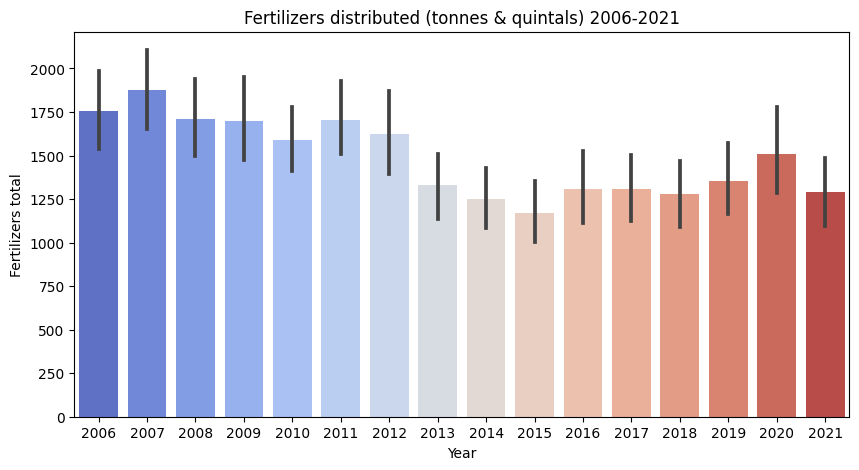

In [51]:
# fertilizer distributed tonnes and quintals
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Fertilizers_tonnes',data = fertilizer, palette='coolwarm')
plt.title('Fertilizers distributed (tonnes & quintals) 2006-2021')
plt.xlabel('Year')
plt.ylabel('Fertilizers total')
plt.show()


In [67]:
fertilizer = fertilizer.nlargest(30, 'Fertilizers_tonnes')

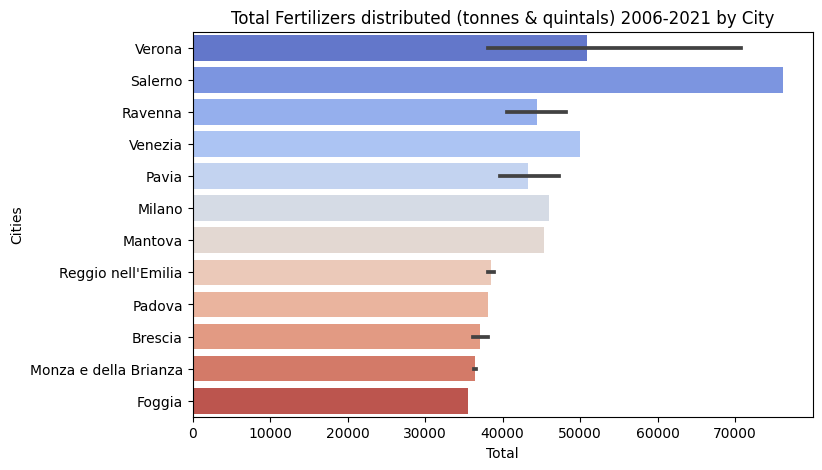

In [69]:
fertilizer= fertilizer.sort_values('Fertilizers_tonnes',ascending=False)

plt.figure(figsize= (8,5))
sns.barplot(x=fertilizer['Fertilizers_tonnes'] ,y= fertilizer ['City'], palette='coolwarm');
plt.title('Total Fertilizers distributed (tonnes & quintals) 2006-2021 by City')
plt.xlabel('Total')
plt.ylabel('Cities')
plt.show()

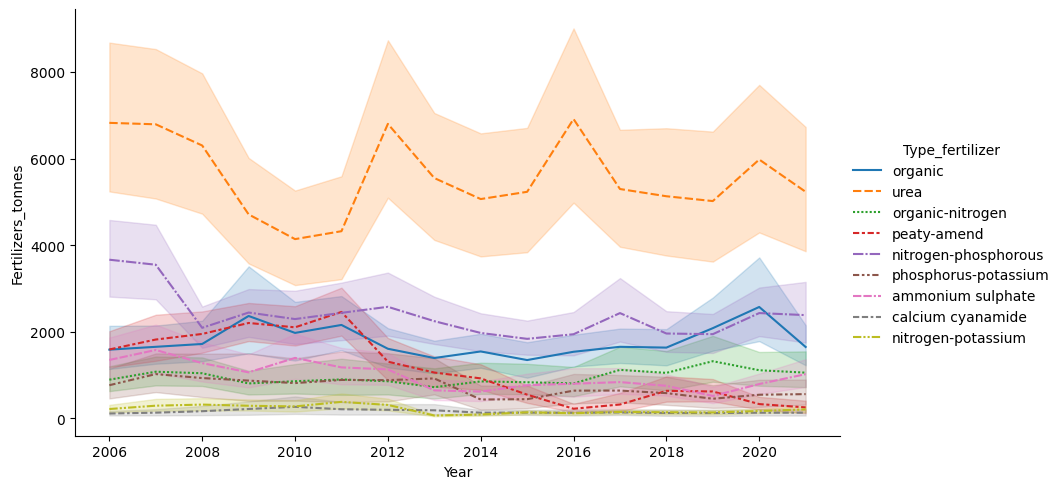

In [53]:
#Fertilizers distributed by year

fertilizer_plot = sns.relplot(kind='line', data=fertilizer, x='Year', y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)


In [54]:
fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
8734,Verona,organic,2009,98671.6
35036,Salerno,organic,2020,76184.0
45832,Verona,urea,2016,51526.0
65142,Ravenna,urea,2016,51523.0
9983,Venezia,organic,2010,50055.6


### Create new dataframe with the selected type of fertilizers as columns

In [55]:
# Create columns for each type of fertilizer 
fertilizer_pivot = fertilizer.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer_pivot

Fertilizers_tonnes                                         \
Type_fertilizer  ammonium sulphate calcium cyanamide nitrogen-phosphorous   
City      Year                                                              
Agrigento 2006               168.7               0.0                497.7   
          2007               217.1               0.0                649.8   
          2008               140.0               0.0                521.3   
          2009               140.4               0.0                380.8   
          2010               141.6              14.0                327.1   
...                            ...               ...                  ...   
Viterbo   2017               153.0               0.0               4732.0   
          2018               149.0               0.0               4376.0   
          2019                70.0               0.0               3964.0   
          2020               176.0               0.0               6145.0   
          2021               152.0               0.0               3946.0   

                                                                         \
Type_fertilizer nitrogen-potassium organic organic-nitrogen peaty-amend   
City      Year                                                            
Agrigento 2006                27.7  3143.9            777.9       296.6   
          2007                49.1  3534.8            607.9       294.9   
          2008                61.4  3750.4           1407.5       350.6   
          2009                46.8  2791.4            898.4       567.8   
          2010                44.0  2346.0            913.6       308.2   
...                            ...     ...              ...         ...   
Viterbo   2017                66.0  1760.0           2268.0       274.0   
          2018                19.0  1591.0           2106.0       811.0   
          2019               195.0  1251.0           2884.0       427.0   
          2020                98.0  1236.0           2935.0       275.0   
          2021               112.0  1056.0           3337.0       131.0   

                                              
Type_fertilizer phosphorus-potassium    urea  
City      Year                                
Agrigento 2006                 209.3   210.0  
          2007                 295.3   510.0  
          2008                 443.8   273.6  
          2009                 359.0   271.6  
          2010                 350.6   296.2  
...                              ...     ...  
Viterbo   2017                 179.0  2859.0  
          2018                  91.0  2863.0  
          2019                  95.0  2413.0  
          2020                 119.0  3578.0  
          2021                 126.0  2054.0  

[1749 rows x 9 columns]

In [56]:
# Drop level
fertilizer_pivot.columns = fertilizer_pivot.columns.droplevel()
fertilizer_pivot

Type_fertilizer  ammonium sulphate  calcium cyanamide  nitrogen-phosphorous  \
City      Year                                                                
Agrigento 2006               168.7                0.0                 497.7   
          2007               217.1                0.0                 649.8   
          2008               140.0                0.0                 521.3   
          2009               140.4                0.0                 380.8   
          2010               141.6               14.0                 327.1   
...                            ...                ...                   ...   
Viterbo   2017               153.0                0.0                4732.0   
          2018               149.0                0.0                4376.0   
          2019                70.0                0.0                3964.0   
          2020               176.0                0.0                6145.0   
          2021               152.0                0.0                3946.0   

Type_fertilizer  nitrogen-potassium  organic  organic-nitrogen  peaty-amend  \
City      Year                                                                
Agrigento 2006                 27.7   3143.9             777.9        296.6   
          2007                 49.1   3534.8             607.9        294.9   
          2008                 61.4   3750.4            1407.5        350.6   
          2009                 46.8   2791.4             898.4        567.8   
          2010                 44.0   2346.0             913.6        308.2   
...                             ...      ...               ...          ...   
Viterbo   2017                 66.0   1760.0            2268.0        274.0   
          2018                 19.0   1591.0            2106.0        811.0   
          2019                195.0   1251.0            2884.0        427.0   
          2020                 98.0   1236.0            2935.0        275.0   
          2021                112.0   1056.0            3337.0        131.0   

Type_fertilizer  phosphorus-potassium    urea  
City      Year                                 
Agrigento 2006                  209.3   210.0  
          2007                  295.3   510.0  
          2008                  443.8   273.6  
          2009                  359.0   271.6  
          2010                  350.6   296.2  
...                               ...     ...  
Viterbo   2017                  179.0  2859.0  
          2018                   91.0  2863.0  
          2019                   95.0  2413.0  
          2020                  119.0  3578.0  
          2021                  126.0  2054.0  

[1749 rows x 9 columns]

In [57]:
#Rename index
fertilizer_pivot = fertilizer_pivot.rename_axis(None,axis=1)
fertilizer_pivot

ammonium sulphate  calcium cyanamide  nitrogen-phosphorous  \
City      Year                                                               
Agrigento 2006              168.7                0.0                 497.7   
          2007              217.1                0.0                 649.8   
          2008              140.0                0.0                 521.3   
          2009              140.4                0.0                 380.8   
          2010              141.6               14.0                 327.1   
...                           ...                ...                   ...   
Viterbo   2017              153.0                0.0                4732.0   
          2018              149.0                0.0                4376.0   
          2019               70.0                0.0                3964.0   
          2020              176.0                0.0                6145.0   
          2021              152.0                0.0                3946.0   

                nitrogen-potassium  organic  organic-nitrogen  peaty-amend  \
City      Year                                                               
Agrigento 2006                27.7   3143.9             777.9        296.6   
          2007                49.1   3534.8             607.9        294.9   
          2008                61.4   3750.4            1407.5        350.6   
          2009                46.8   2791.4             898.4        567.8   
          2010                44.0   2346.0             913.6        308.2   
...                            ...      ...               ...          ...   
Viterbo   2017                66.0   1760.0            2268.0        274.0   
          2018                19.0   1591.0            2106.0        811.0   
          2019               195.0   1251.0            2884.0        427.0   
          2020                98.0   1236.0            2935.0        275.0   
          2021               112.0   1056.0            3337.0        131.0   

                phosphorus-potassium    urea  
City      Year                                
Agrigento 2006                 209.3   210.0  
          2007                 295.3   510.0  
          2008                 443.8   273.6  
          2009                 359.0   271.6  
          2010                 350.6   296.2  
...                              ...     ...  
Viterbo   2017                 179.0  2859.0  
          2018                  91.0  2863.0  
          2019                  95.0  2413.0  
          2020                 119.0  3578.0  
          2021                 126.0  2054.0  

[1749 rows x 9 columns]

In [58]:
# Reset index
fertilizer_pivot = fertilizer_pivot.reset_index()
fertilizer_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen-phosphorous,nitrogen-potassium,organic,organic-nitrogen,peaty-amend,phosphorus-potassium,urea
0,Agrigento,2006,168.7,0.0,497.7,27.7,3143.9,777.9,296.6,209.3,210.0
1,Agrigento,2007,217.1,0.0,649.8,49.1,3534.8,607.9,294.9,295.3,510.0
2,Agrigento,2008,140.0,0.0,521.3,61.4,3750.4,1407.5,350.6,443.8,273.6
3,Agrigento,2009,140.4,0.0,380.8,46.8,2791.4,898.4,567.8,359.0,271.6
4,Agrigento,2010,141.6,14.0,327.1,44.0,2346.0,913.6,308.2,350.6,296.2
...,...,...,...,...,...,...,...,...,...,...,...
1744,Viterbo,2017,153.0,0.0,4732.0,66.0,1760.0,2268.0,274.0,179.0,2859.0
1745,Viterbo,2018,149.0,0.0,4376.0,19.0,1591.0,2106.0,811.0,91.0,2863.0
1746,Viterbo,2019,70.0,0.0,3964.0,195.0,1251.0,2884.0,427.0,95.0,2413.0
1747,Viterbo,2020,176.0,0.0,6145.0,98.0,1236.0,2935.0,275.0,119.0,3578.0


#### Join crop and fertilizers datasets

In [59]:
# Join both datasets 
it_crop_ferlizer = pd.merge(industrial_crop_top10_pivot, fertilizer_pivot, on=['Year', 'City'], how='left').fillna(0)
it_crop_ferlizer

,City,Year,basil-ghouse,flax,hemp,parsley-field,parsley-ghouse,rape,soya beans,sunflower,...,valerian-ghouse,ammonium sulphate,calcium cyanamide,nitrogen-phosphorous,nitrogen-potassium,organic,organic-nitrogen,peaty-amend,phosphorus-potassium,urea
0,Agrigento,2020,0.0,0.0,0.0,15.5,0.0,0.0,0.0,0.0,...,0.0,155.0,12.0,918.0,119.0,3462.0,865.0,80.0,235.0,488.0
1,Alessandria,2020,0.0,132.0,104.0,612.0,0.0,2897.5,11924.5,17730.0,...,0.0,135.0,105.0,1409.0,519.0,4050.0,1472.0,14.0,1109.0,7834.0
2,Ancona,2020,1.5,0.0,230.0,0.0,0.2,207.0,473.6,24043.5,...,0.0,567.0,17.0,7250.0,65.0,2533.0,683.0,71.0,16.0,14412.0
3,Arezzo,2020,3.0,4.0,665.0,14.0,1.2,1053.0,125.0,11970.0,...,0.0,68.0,26.0,820.0,17.0,2619.0,2533.0,245.0,97.0,1723.0
4,Ascoli Piceno,2020,0.2,0.0,0.0,40.0,0.7,0.0,77.6,15065.9,...,0.0,8.0,158.0,562.0,37.0,812.0,630.0,361.0,51.0,603.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Verbano-Cusio-Ossola,2020,0.0,0.0,7.5,0.0,0.0,0.0,45.0,0.0,...,0.0,0.0,0.0,0.0,0.0,352.0,13.0,220.0,0.0,0.0
93,Vercelli,2020,0.0,0.0,0.0,0.0,0.0,416.3,7099.2,110.7,...,0.0,14.0,2570.0,3465.0,143.0,7793.0,5192.0,15.0,12085.0,3848.0
94,Verona,2020,4530.9,0.0,516.0,108.0,951.5,2151.5,48016.0,8583.0,...,780.0,3919.0,258.0,17066.0,1447.0,12781.0,6851.0,1158.0,1824.0,41076.0
95,Vicenza,2020,0.0,4.0,60.0,0.0,0.0,1059.0,36808.0,1465.0,...,47.0,1350.0,225.0,1387.0,550.0,1770.0,1943.0,1078.0,98.0,5637.0


### Correlation

In [60]:

crop = it_crop_ferlizer.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer[['valerian-ghouse', 'basil-ghouse', 'sunflower', 'rape', 
                                  'soya beans', 'hemp', 'parsley-field','parsley-ghouse',
                                  'tobacco', 'flax','calcium cyanamide','nitrogen-potassium',
                                 'organic', 'phosphorus-potassium','urea']] 


<AxesSubplot: title={'center': 'Correlation'}>

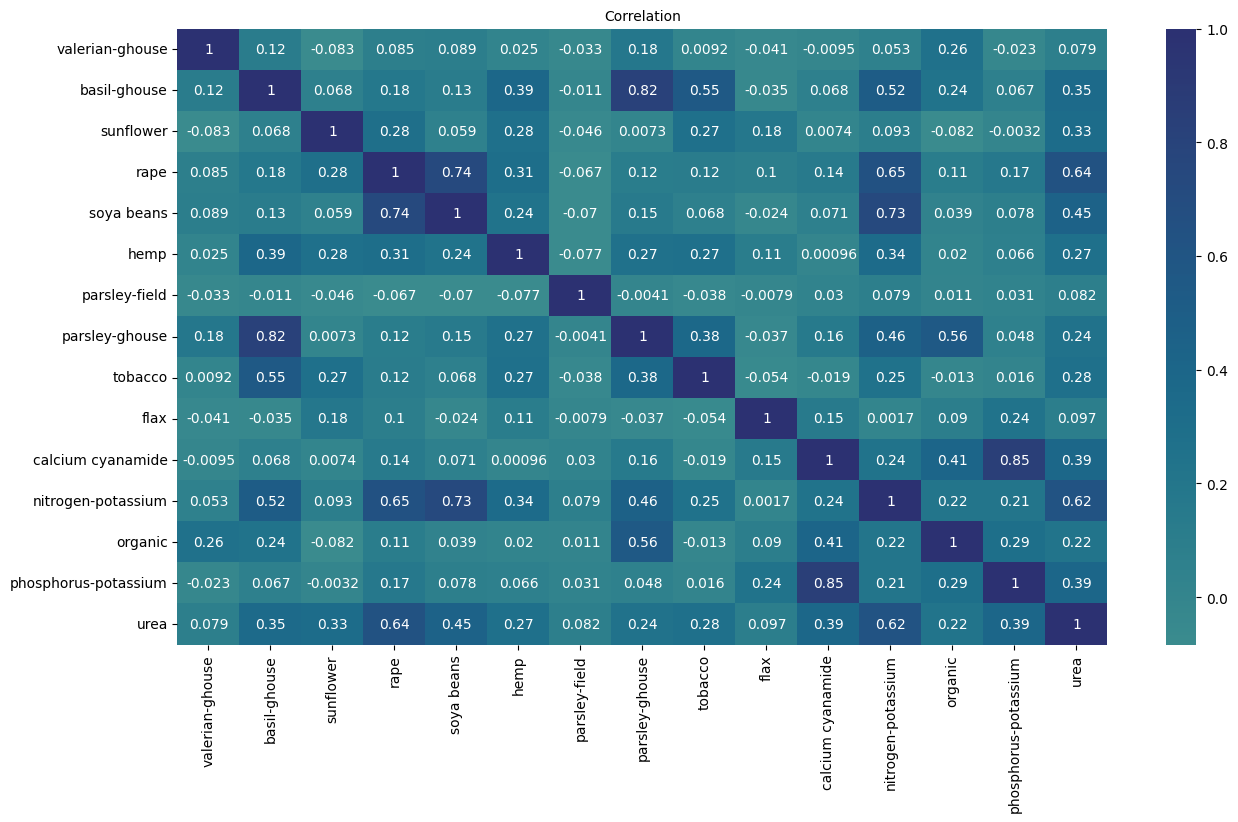

In [70]:
plt.figure(figsize=(15,8))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of industrial crop production in Italy 

* Valerian in greenhouse has low correlation with fertilizer and other industrial crops.

* Sunflower has low correlation with fertilizer and other industrial crops.

* Soya beans has high correlation with Rape.

* Hemp has low correlation Basil greenhouse, Soya and Rape.

* Basil has high correlation with Pasley in greenhouses, Hemp, Soya and Rape.

* Tobacco and Flax have low correlation with fertilizers and other crops.

* There is also hight correlation between urea, phosphorus and potassium with nitrogen fertilizer.


### Calculating Variance Inflation Factor (VIF) for all given features

In [62]:
# Function to compute the VIF
def compute_vif(selected_features):
    
    y = cor_selected [selected_features]
    # the calculation of variance inflation requires a constant
    y['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Feature"] = y.columns
    vif["VIF"] = [variance_inflation_factor(y.values, i) for i in range(y.shape[1])]
    vif = vif[vif['Feature']!='intercept']
    return vif

In [63]:
# Features selection
selected_features = ['valerian-ghouse', 'basil-ghouse', 'sunflower', 'rape', 
                      'soya beans', 'hemp', 'parsley-field','parsley-ghouse',
                      'tobacco', 'flax','calcium cyanamide','nitrogen-potassium',
                      'organic', 'phosphorus-potassium','urea']

# compute vif 
compute_vif(selected_features).sort_values('VIF', ascending=False)


,Feature,VIF
1,basil-ghouse,6.908404
7,parsley-ghouse,6.891117
10,calcium cyanamide,4.622617
11,nitrogen-potassium,4.620956
13,phosphorus-potassium,4.418672
4,soya beans,4.076582
3,rape,3.361341
14,urea,2.762908
12,organic,2.633518
8,tobacco,1.657145


Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html